### Plots of output generation

In [18]:
import os
import sys

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import matplotlib.pyplot as plt
import pandas as pd
from constants import (HYDROGEN_TYPES, NO_NODES, TECH_TO_COLOR,
                       WIND_FARM_NODES, WIND_FARM_NODES_TO_COLOR)
from cycler import cycler

CASES = ["Base", "NOgrid", "NoHubs", "NoHubsNOgrid", "OnlyCentral", "OnlyEU", "OnlyNorth"]
DF_BY_CASES = dict({})

for case in CASES:
    _df = pd.read_csv(f'../Results/{case}/results_output_gen.csv')
    DF_BY_CASES[case] = _df

DF_BY_CASES

{'Base':           Node         GeneratorType     Period  genInvCap_MW  \
 0      BosniaH      Liginiteexisting  2020-2025  0.000000e+00   
 1      BosniaH      Liginiteexisting  2025-2030  0.000000e+00   
 2      BosniaH      Liginiteexisting  2030-2035  0.000000e+00   
 3      BosniaH      Liginiteexisting  2035-2040  0.000000e+00   
 4      BosniaH      Liginiteexisting  2040-2045  0.000000e+00   
 ...        ...                   ...        ...           ...   
 5899  SørvestD  Windoffshorefloating  2035-2040  1.664920e-05   
 5900  SørvestD  Windoffshorefloating  2040-2045  2.285531e-04   
 5901  SørvestD  Windoffshorefloating  2045-2050  9.332931e-03   
 5902  SørvestD  Windoffshorefloating  2050-2055  9.369810e-07   
 5903  SørvestD  Windoffshorefloating  2055-2060  8.311450e-06   
 
       genInstalledCap_MW  genExpectedCapacityFactor  \
 0            1888.000000               7.500000e-01   
 1            1161.846154               7.260993e-01   
 2             780.615385     

In [19]:
""" colors = [*plt.get_cmap('tab20c').colors, *plt.get_cmap('tab20b').colors]
nodes_sorted = ['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'SørvestF', 'Hornsea', 'SørvestB', 'FirthofForth', 'VestavindA', 'Norfolk', 'SørvestA', 'NordvestC', 'EastAnglia', 'OuterDowsing', 'MorayFirth', 'SørvestD', 'SørvestC', 'HollandseeKust', 'NordvestA', 'Borssele', 'SørvestE', 'VestavindC', 'SønnavindA', 'NordvestB', 'VestavindB', 'NordavindA', 'VestavindD', 'VestavindF', 'VestavindE', 'NordavindD', 'NordavindC', 'NordavindB']
NODE_TO_COLOR = dict({})

for i in range(len(nodes_sorted)):
    NODE_TO_COLOR[nodes_sorted[i]] = colors[i]

NODE_TO_COLOR """

" colors = [*plt.get_cmap('tab20c').colors, *plt.get_cmap('tab20b').colors]\nnodes_sorted = ['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'SørvestF', 'Hornsea', 'SørvestB', 'FirthofForth', 'VestavindA', 'Norfolk', 'SørvestA', 'NordvestC', 'EastAnglia', 'OuterDowsing', 'MorayFirth', 'SørvestD', 'SørvestC', 'HollandseeKust', 'NordvestA', 'Borssele', 'SørvestE', 'VestavindC', 'SønnavindA', 'NordvestB', 'VestavindB', 'NordavindA', 'VestavindD', 'VestavindF', 'VestavindE', 'NordavindD', 'NordavindC', 'NordavindB']\nNODE_TO_COLOR = dict({})\n\nfor i in range(len(nodes_sorted)):\n    NODE_TO_COLOR[nodes_sorted[i]] = colors[i]\n\nNODE_TO_COLOR "

In [20]:
def plot_gen_by_source(case, _df):
    print(f"Generation by source for case: {case}")
    
    df_gen_source = _df.copy()
    df_gen_source = df_gen_source[~df_gen_source["GeneratorType"].isin(HYDROGEN_TYPES)]

    NS_OW_prod_2050 = df_gen_source[(df_gen_source["Node"].isin(WIND_FARM_NODES)) & (df_gen_source["Period"] == "2045-2050")]\
                    ["genInstalledCap_MW"].sum() / 1000 # in GW

    df_gen_source["genInstalledCap_MW"] = df_gen_source.groupby(['GeneratorType', 'Period'])['genInstalledCap_MW'].transform('sum')
    df_gen_source = df_gen_source.drop_duplicates(("GeneratorType", "Period"), ignore_index=True)[["GeneratorType", "Period", "genInstalledCap_MW"]]

    periods = list(df_gen_source["Period"].unique())

    gen_source_sorted_by_cap = list(df_gen_source[df_gen_source["Period"] == "2055-2060"]\
                              .sort_values(by="genInstalledCap_MW", ascending=False)["GeneratorType"].values)
        
    gen_source_displayed = gen_source_sorted_by_cap

    installed_caps_gen = []
    for gen_source in gen_source_displayed:
        cap_by_period = []
        for period in periods:
            cap_by_period.append(df_gen_source[(df_gen_source["GeneratorType"] == gen_source) & (df_gen_source["Period"] == period)]["genInstalledCap_MW"].values[0])

        # Remove gen_source that have no capacity (1 MW since some threshold)
        if all(c < 1 for c in cap_by_period):
            gen_source_displayed.remove(gen_source)
        else:
            installed_caps_gen.append(cap_by_period)

    installed_caps_gen_TW = [[cap/1000000 for cap in sublist] for sublist in installed_caps_gen]
    period_displayed_gen = [period.split("-")[1] for period in periods]

    print(gen_source_displayed)

    plt.rcParams.update({'font.size': 14})
    default_cycler = cycler(color=[TECH_TO_COLOR[tech] for tech in gen_source_displayed])
    plt.figure(figsize=(10,6))
    plt.rc('axes', axisbelow=True, prop_cycle=default_cycler)
    plt.grid(linewidth=0.3)
    plt.stackplot(period_displayed_gen, installed_caps_gen_TW, labels=gen_source_displayed, edgecolor='white', lw=0.7)
    plt.ylabel('Generator capacity [TW]')
    plt.margins(x=0)

    y_max = 6
    plt.ylim(0, y_max)
    
    # Plot capacity 2050 
    prod_2050 = sum([gen_cap[5] for gen_cap in installed_caps_gen_TW]) # Total gen in TW

    # Align text based on height of peak
    # prod_by_periods = [sum([gen_cap[i] for gen_cap in installed_caps_gen_TW]) for i in range(8)]
    # max_prod = max(prod_by_periods)

    plt.axvline(x = 5, color = 'black', ls="--")
    plt.text(x=1.9, y=y_max*0.95, s=f"Total capacity in 2050: {round(prod_2050, 1)} TW", verticalalignment='top', fontsize=14)
    plt.text(x=1.9, y=y_max*0.88, s=f"OW capacity in NS 2050: {round(NS_OW_prod_2050)} GW", verticalalignment='top', fontsize=14)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=5, fontsize=10)
    plt.show()

Generation by source for case: Base
['Windonshore', 'Solar', 'Bio', 'Nuclear', 'Windoffshoregrounded', 'GasOCGT', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Windoffshorefloating', 'Lignite', 'Bio10cofiring', 'Waste', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


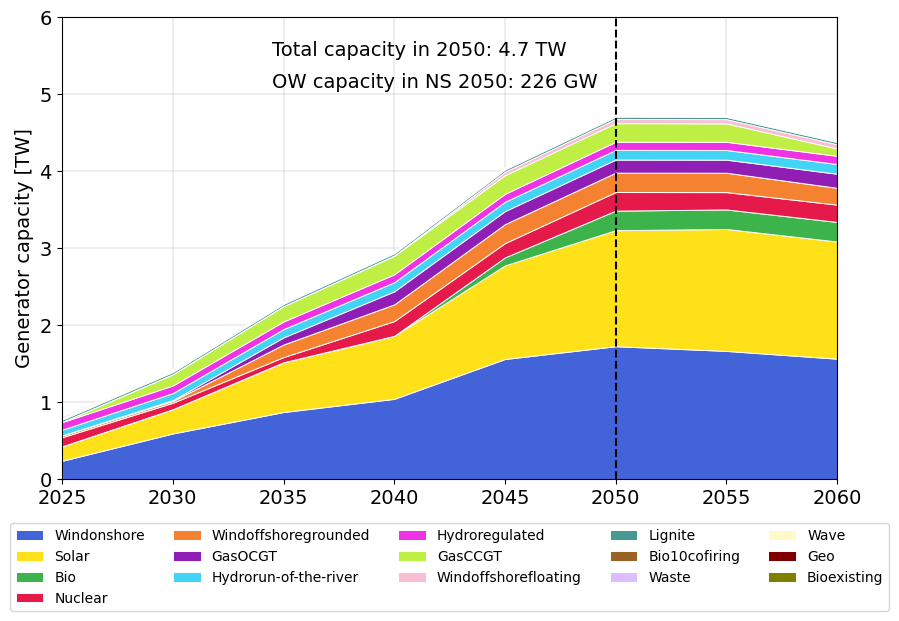

Generation by source for case: NOgrid
['Windonshore', 'Solar', 'Nuclear', 'Bio', 'Windoffshoregrounded', 'GasOCGT', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Lignite', 'Windoffshorefloating', 'Bio10cofiring', 'Waste', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


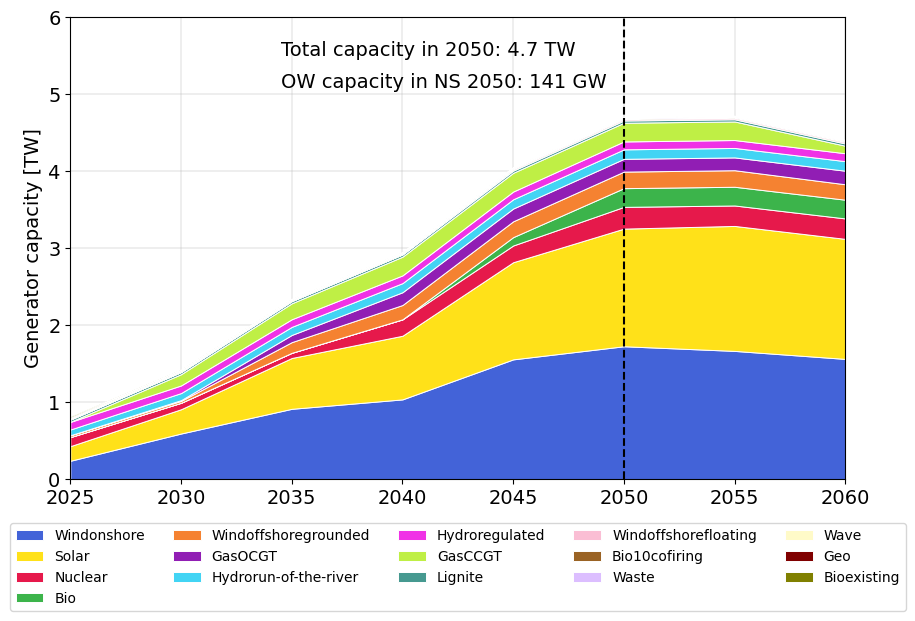

Generation by source for case: NoHubs
['Solar', 'Windonshore', 'Bio', 'Nuclear', 'GasOCGT', 'Windoffshoregrounded', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Lignite', 'Windoffshorefloating', 'Bio10cofiring', 'Waste', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


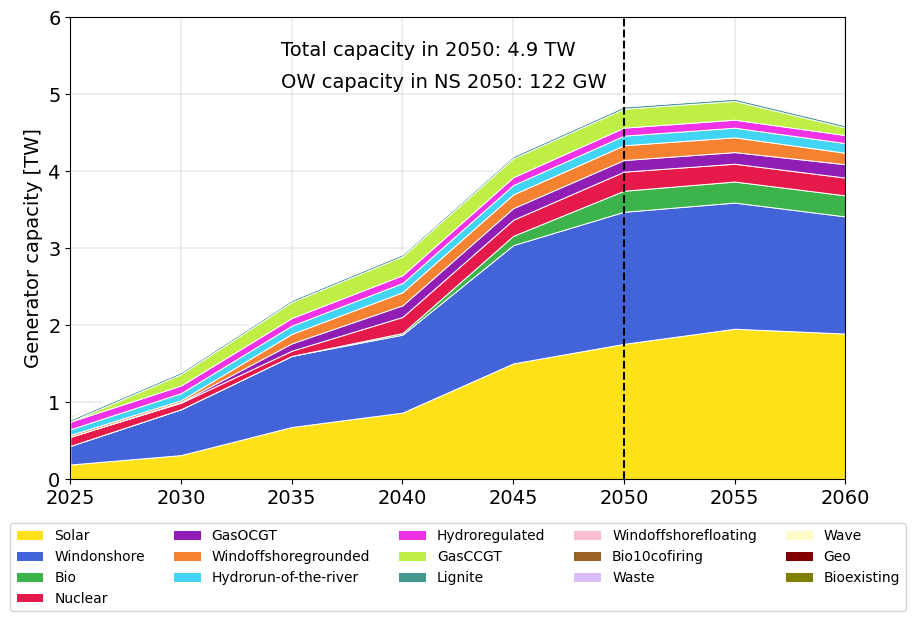

Generation by source for case: NoHubsNOgrid
['Solar', 'Windonshore', 'Bio', 'Nuclear', 'GasOCGT', 'Windoffshoregrounded', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Lignite', 'Bio10cofiring', 'Waste', 'Windoffshorefloating', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


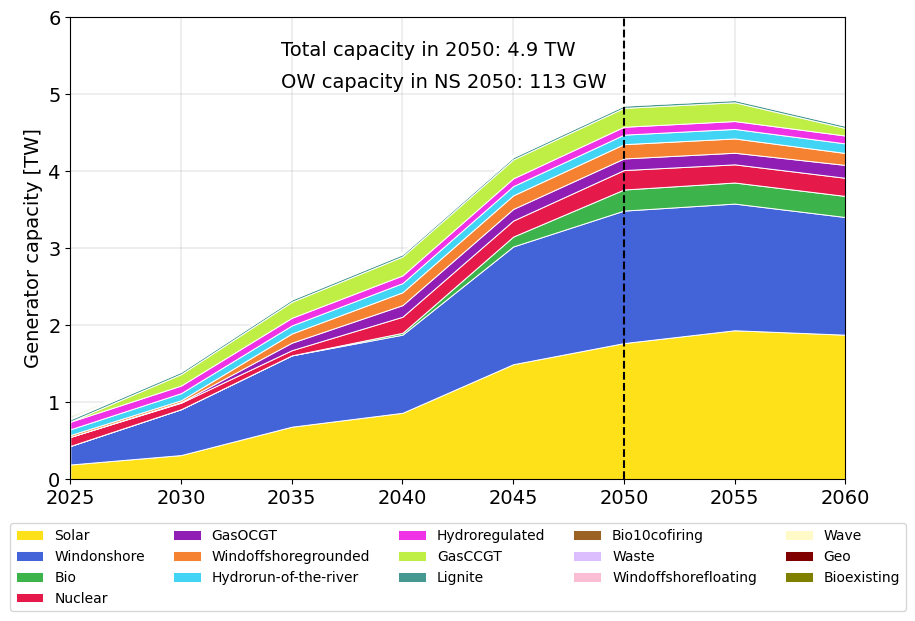

Generation by source for case: OnlyCentral
['Solar', 'Windonshore', 'Bio', 'Nuclear', 'Windoffshoregrounded', 'GasOCGT', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Lignite', 'Windoffshorefloating', 'Bio10cofiring', 'Waste', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


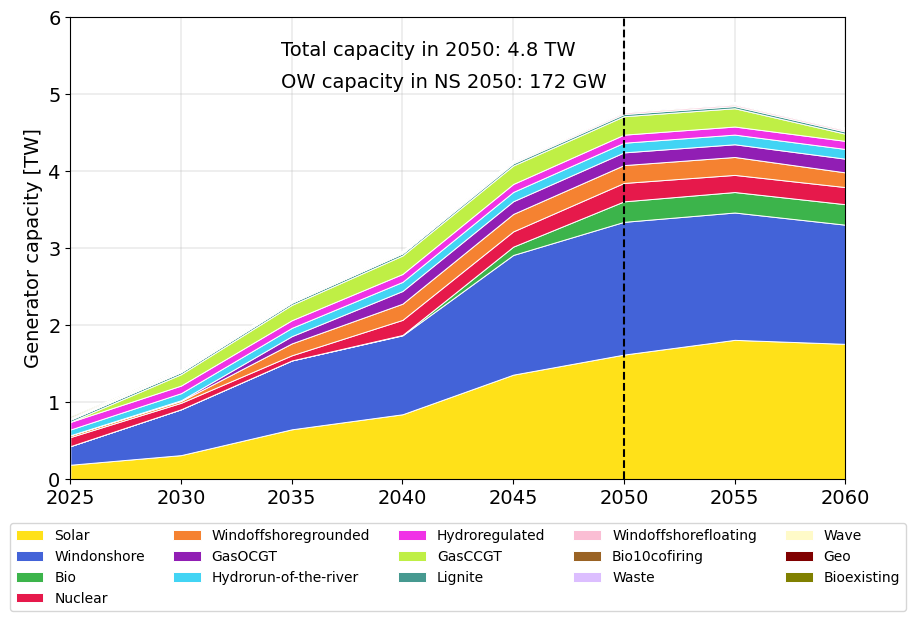

Generation by source for case: OnlyEU
['Solar', 'Windonshore', 'Bio', 'Nuclear', 'Windoffshoregrounded', 'GasOCGT', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Lignite', 'Windoffshorefloating', 'Bio10cofiring', 'Waste', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


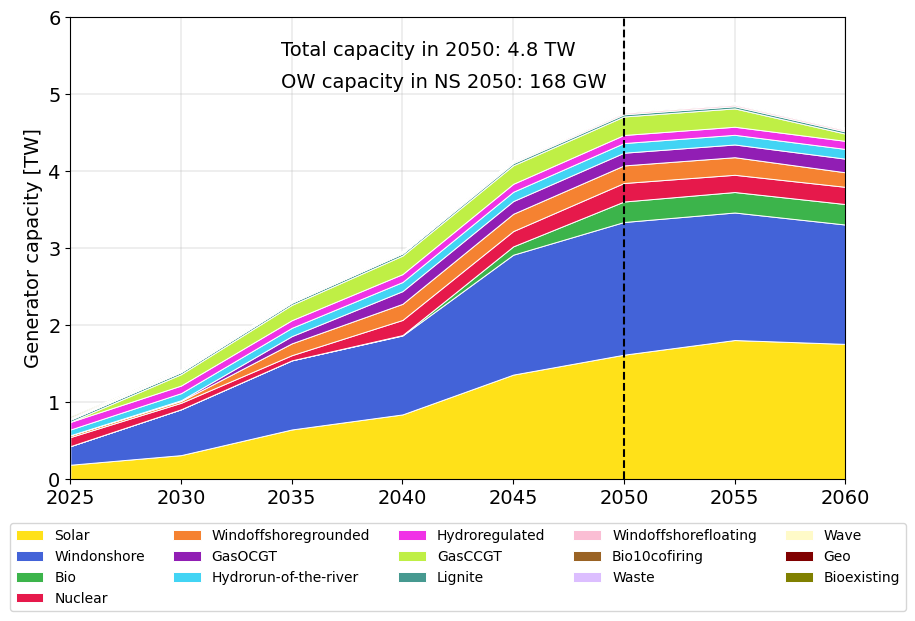

Generation by source for case: OnlyNorth
['Solar', 'Windonshore', 'Bio', 'Nuclear', 'Windoffshoregrounded', 'GasOCGT', 'Hydrorun-of-the-river', 'Hydroregulated', 'GasCCGT', 'Lignite', 'Windoffshorefloating', 'Bio10cofiring', 'Waste', 'Wave', 'Geo', 'Bioexisting', 'Oilexisting', 'Gasexisting', 'Bio10cofiringCCS', 'CoalCCS', 'Coalexisting', 'Liginiteexisting']


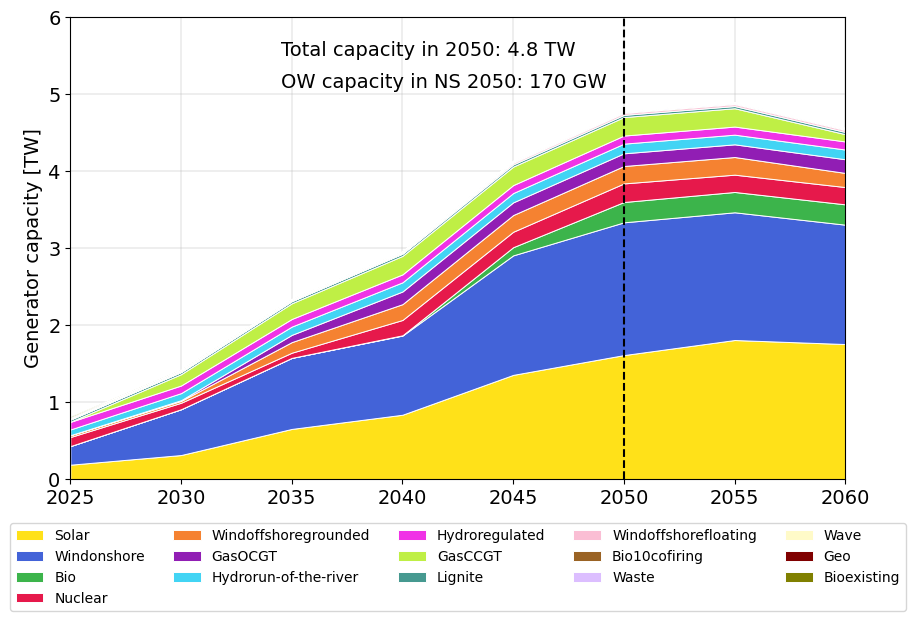

In [21]:
for case, _df in DF_BY_CASES.items():
    plot_gen_by_source(case, _df)

#### By wind farm nodes (combined floating + grounded tech)

In [22]:
def plot_wind_prod(case, _df):
    print(f"Wind production (floating + grounded) by area for case: {case}")

    df_wind_farm_nodes = _df[_df['Node'].isin(WIND_FARM_NODES)]

    # Sum floating + grounded cap
    df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')
    df_wind_farm_nodes = df_wind_farm_nodes.drop_duplicates(("Node", "Period"), ignore_index=True)[["Node", "Period", "genInstalledCap_MW"]]
    
    df_NO_nodes = df_wind_farm_nodes[df_wind_farm_nodes["Node"].isin(NO_NODES)]
    prod_NO_2050 = df_NO_nodes[df_NO_nodes["Period"] == "2045-2050"]["genInstalledCap_MW"].sum()

    print(f"NO prod in 2050: {round(prod_NO_2050/1000, 1)} GW")

    periods = list(df_wind_farm_nodes["Period"].unique())
    nodes_sorted_by_cap = list(df_wind_farm_nodes[df_wind_farm_nodes["Period"] == "2055-2060"].sort_values(by="genInstalledCap_MW", ascending=False)["Node"].values)
    
    nodes_displayed = nodes_sorted_by_cap
    
    installed_caps = []
    for node in nodes_displayed:
        cap_by_period = []
        for period in periods:
            cap_by_period.append(df_wind_farm_nodes[(df_wind_farm_nodes["Node"] == node) & (df_wind_farm_nodes["Period"] == period)]["genInstalledCap_MW"].values[0])

        # Remove nodes that have no capacity (1 MW since some threshold)
        if all(c < 1 for c in cap_by_period):
            nodes_displayed.remove(node)
        else:
            installed_caps.append(cap_by_period)

    installed_caps_GW = [[cap/1000 for cap in sublist] for sublist in installed_caps]
    period_displayed = [period.split("-")[1] for period in periods]

    print(nodes_displayed)

    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10,6))
    default_cycler = cycler(color=[WIND_FARM_NODES_TO_COLOR[node] for node in nodes_displayed])
    plt.rc('axes', axisbelow=True, prop_cycle=default_cycler)
    plt.grid(lw=0.3)
    plt.stackplot(period_displayed, installed_caps_GW, labels=nodes_displayed, edgecolor="white", lw=0.7)
    plt.ylabel('Wind power capacity [GW]')
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=5, fontsize=10)
    plt.margins(x=0)

    y_max = 300
    plt.ylim(0, y_max)

    # Plot capacity 2050 
    prod_2050 = sum([cap[5] for cap in installed_caps_GW]) # Total cap in GW

    # Align text based on height of peak
    # prod_by_periods = [sum([cap[i] for cap in installed_caps_GW]) for i in range(8)]
    # max_prod = max(prod_by_periods)

    plt.axvline(x = 5, color = 'black', ls="--")
    plt.text(x=2.4, y=y_max*0.9, s=f"Capacity in 2050: {round(prod_2050, 1)} GW", verticalalignment='top', fontsize=14)
    plt.show()

Wind production (floating + grounded) by area for case: Base
NO prod in 2050: 103.3 GW
['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'SørvestF', 'Hornsea', 'SørvestB', 'FirthofForth', 'NordvestC', 'SønnavindA', 'VestavindA', 'MorayFirth', 'Norfolk', 'SørvestA', 'EastAnglia', 'OuterDowsing', 'SørvestE', 'NordvestB', 'HollandseeKust', 'SørvestD', 'SørvestC', 'NordvestA', 'Borssele', 'VestavindC', 'VestavindB', 'NordavindA', 'VestavindF', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


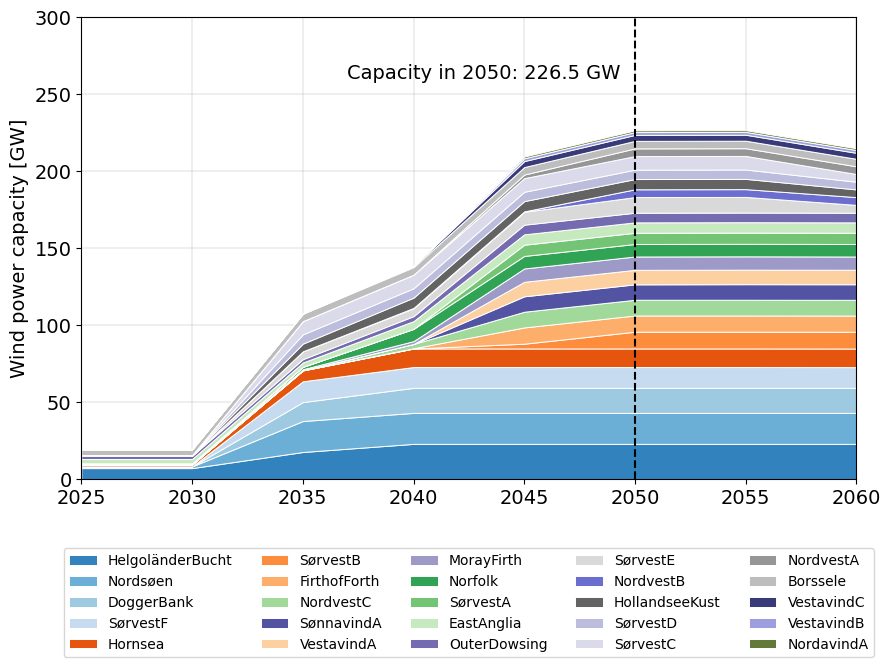

Wind production (floating + grounded) by area for case: NOgrid
NO prod in 2050: 10.4 GW
['HelgoländerBucht', 'Nordsøen', 'MorayFirth', 'DoggerBank', 'Hornsea', 'FirthofForth', 'Norfolk', 'EastAnglia', 'HollandseeKust', 'OuterDowsing', 'Borssele', 'NordvestB', 'SørvestF', 'NordavindA', 'NordvestA', 'NordvestC', 'VestavindA', 'SørvestE', 'SørvestC', 'SørvestA', 'SørvestB', 'VestavindE', 'NordavindD', 'SønnavindA']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


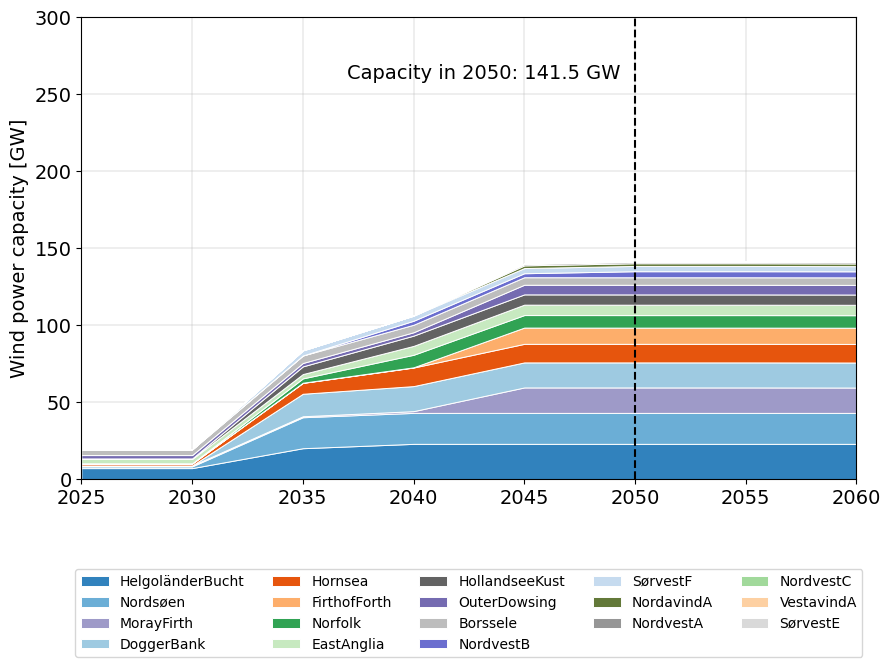

Wind production (floating + grounded) by area for case: NoHubs
NO prod in 2050: 22.6 GW
['HelgoländerBucht', 'DoggerBank', 'FirthofForth', 'Hornsea', 'Nordsøen', 'Norfolk', 'HollandseeKust', 'OuterDowsing', 'MorayFirth', 'EastAnglia', 'SørvestF', 'SørvestE', 'Borssele', 'VestavindA', 'NordvestA', 'VestavindC', 'NordvestB', 'NordvestC', 'NordavindA', 'VestavindB', 'SørvestD', 'VestavindF', 'VestavindE', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


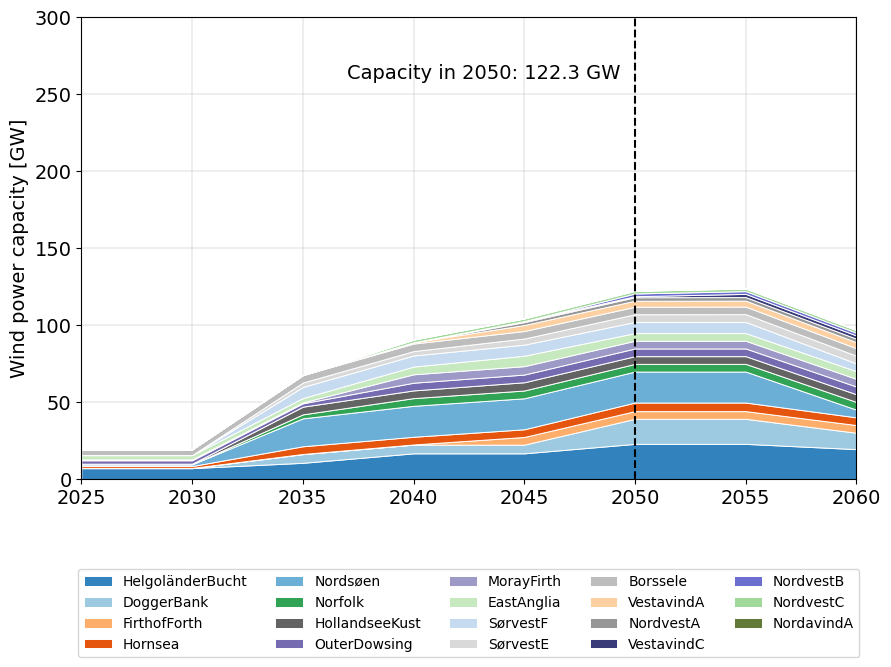

Wind production (floating + grounded) by area for case: NoHubsNOgrid
NO prod in 2050: 10.3 GW
['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'FirthofForth', 'Hornsea', 'Norfolk', 'HollandseeKust', 'OuterDowsing', 'EastAnglia', 'MorayFirth', 'Borssele', 'NordvestB', 'SørvestF', 'NordavindA', 'NordvestA', 'VestavindA', 'SørvestE', 'VestavindB', 'VestavindC', 'SørvestB', 'VestavindE', 'NordavindC', 'SønnavindA']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


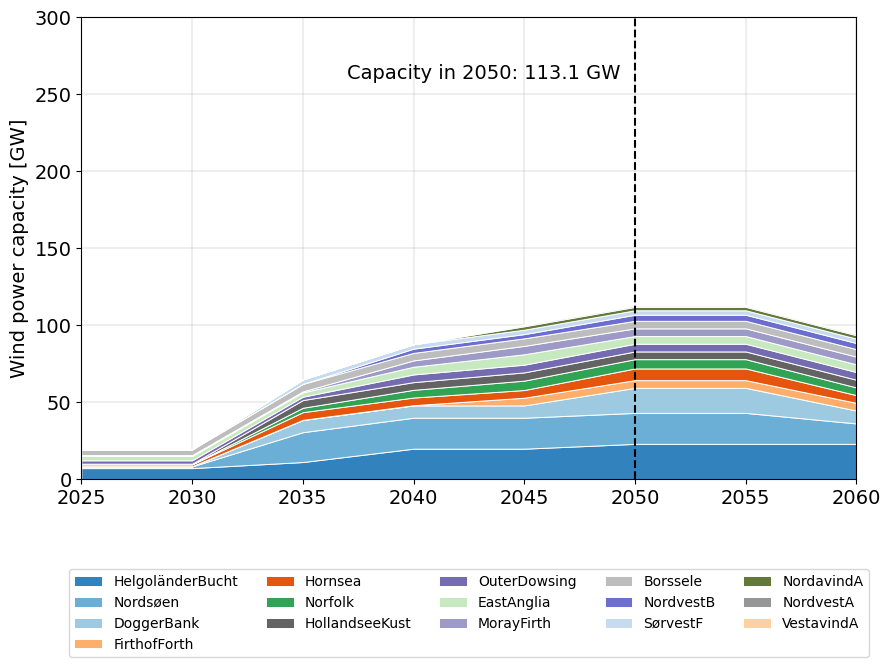

Wind production (floating + grounded) by area for case: OnlyCentral
NO prod in 2050: 57.5 GW
['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'Hornsea', 'Norfolk', 'EastAnglia', 'OuterDowsing', 'SørvestF', 'MorayFirth', 'FirthofForth', 'VestavindA', 'HollandseeKust', 'SørvestC', 'SørvestD', 'SørvestE', 'Borssele', 'SørvestB', 'NordvestA', 'NordvestB', 'NordvestC', 'VestavindC', 'NordavindA', 'SørvestA', 'SønnavindA', 'VestavindF', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


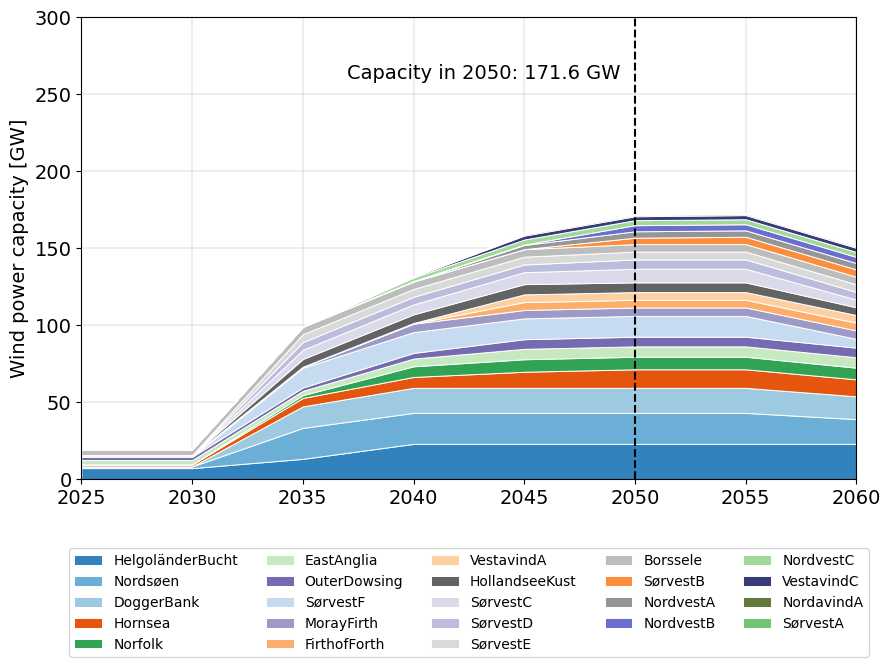

Wind production (floating + grounded) by area for case: OnlyEU
NO prod in 2050: 52.9 GW
['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'Hornsea', 'SørvestF', 'Norfolk', 'EastAnglia', 'OuterDowsing', 'FirthofForth', 'MorayFirth', 'HollandseeKust', 'VestavindA', 'SørvestC', 'Borssele', 'SørvestD', 'NordvestA', 'NordvestB', 'SørvestE', 'NordvestC', 'VestavindC', 'NordavindA', 'SønnavindA', 'SørvestA', 'SørvestB', 'VestavindD', 'VestavindE', 'NordavindC']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


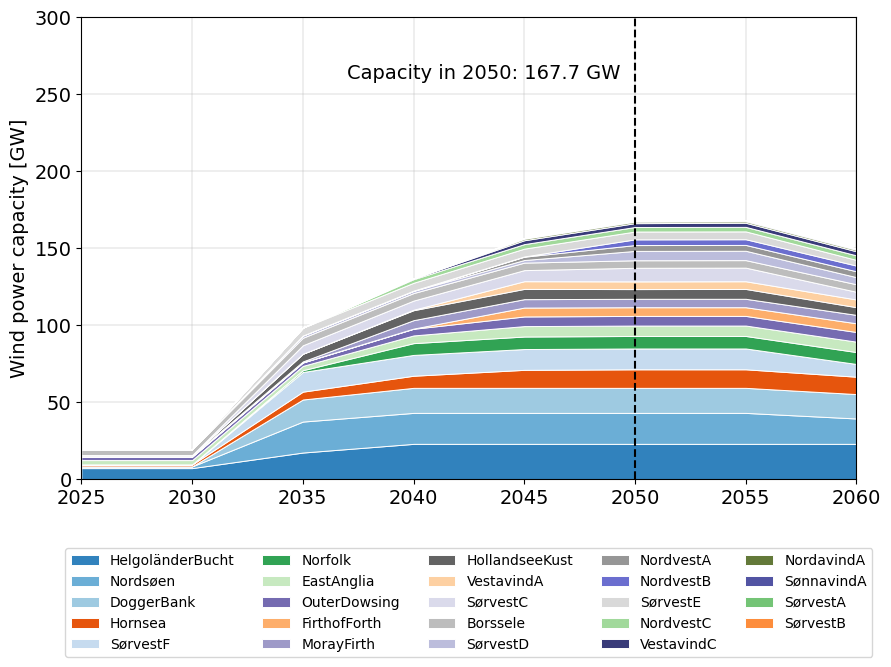

Wind production (floating + grounded) by area for case: OnlyNorth
NO prod in 2050: 58.1 GW
['HelgoländerBucht', 'Nordsøen', 'DoggerBank', 'Hornsea', 'NordvestC', 'EastAnglia', 'VestavindA', 'Norfolk', 'SørvestF', 'OuterDowsing', 'MorayFirth', 'FirthofForth', 'HollandseeKust', 'SørvestC', 'Borssele', 'SørvestD', 'SørvestA', 'NordvestA', 'SørvestE', 'VestavindC', 'NordvestB', 'NordavindA', 'SørvestB', 'SønnavindA', 'VestavindF', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/144819096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


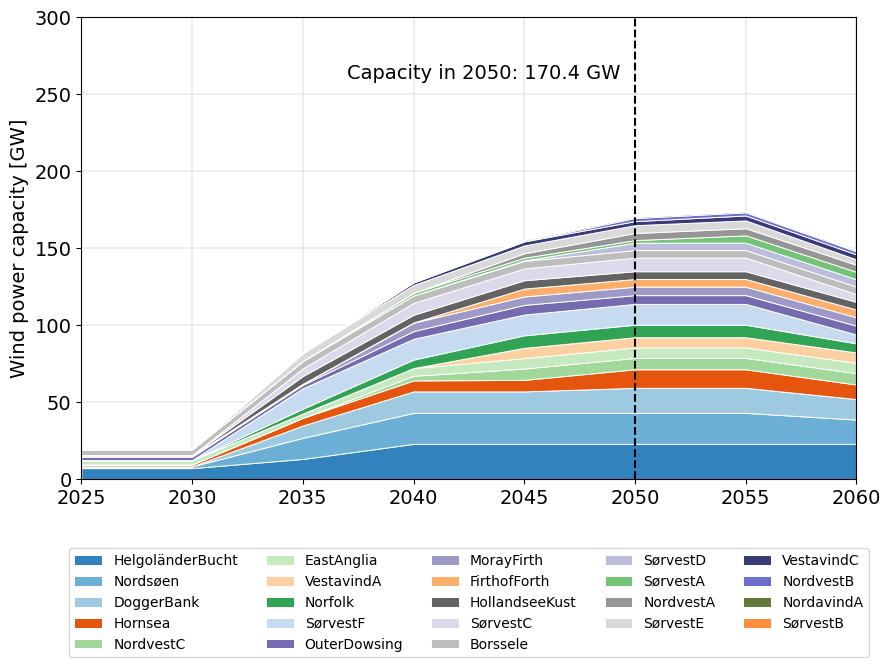

In [15]:
for case, _df in DF_BY_CASES.items():
    plot_wind_prod(case, _df)

#### By NO wind farm nodes

In [16]:
def plot_wind_prod_NO(case, _df):
    print(f"Wind production (floating + grounded) for NO areas for case: {case}")
    df_wind_farm_nodes = _df[_df['Node'].isin(NO_NODES)]

    # Sum floating + grounded cap
    df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')
    df_wind_farm_nodes = df_wind_farm_nodes.drop_duplicates(("Node", "Period"), ignore_index=True)[["Node", "Period", "genInstalledCap_MW"]]
    
    prod_NO_2050 = df_wind_farm_nodes[df_wind_farm_nodes["Period"] == "2045-2050"]["genInstalledCap_MW"].sum()

    print(f"NO prod in 2050: {round(prod_NO_2050/1000, 1)} GW")

    periods = list(df_wind_farm_nodes["Period"].unique())
    nodes_sorted_by_cap = list(df_wind_farm_nodes[df_wind_farm_nodes["Period"] == "2055-2060"].sort_values(by="genInstalledCap_MW", ascending=False)["Node"].values)
    
    nodes_displayed = nodes_sorted_by_cap

    installed_caps = []
    for node in nodes_displayed:
        cap_by_period = []
        for period in periods:
            cap_by_period.append(df_wind_farm_nodes[(df_wind_farm_nodes["Node"] == node) & (df_wind_farm_nodes["Period"] == period)]["genInstalledCap_MW"].values[0])

        # Remove nodes that have no capacity (1 MW since some threshold)
        if all(c < 1 for c in cap_by_period):
            nodes_displayed.remove(node)
        else:
            installed_caps.append(cap_by_period)

    installed_caps_GW = [[cap/1000 for cap in sublist] for sublist in installed_caps]
    period_displayed = [period.split("-")[1] for period in periods]

    print(nodes_displayed)

    plt.rcParams.update({'font.size': 14})
    default_cycler = cycler(color=[WIND_FARM_NODES_TO_COLOR[node] for node in nodes_displayed])
    plt.figure(figsize=(10,6))
    plt.rc('axes', axisbelow=True, prop_cycle=default_cycler)
    plt.grid(lw=0.3)
    plt.stackplot(period_displayed, installed_caps_GW, labels=nodes_displayed, edgecolor="white", lw=0.7)
    plt.ylabel('Wind power capacity [GW]')
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=5, fontsize=10)
    plt.margins(x=0)

    y_max = 120
    plt.ylim(0, y_max)


    # Plot capacity 2050 
    cap_2050 = sum([cap[5] for cap in installed_caps_GW]) # Total cap in GW
    
    plt.axvline(x = 5, color = 'black', ls="--")
    plt.text(x=2.5, y=y_max*0.9, s=f"Capacity in 2050: {round(cap_2050, 1)} GW", verticalalignment='top', fontsize=14)
    plt.show()

Wind production (floating + grounded) for NO areas for case: Base
NO prod in 2050: 103.3 GW
['SørvestF', 'SørvestB', 'NordvestC', 'SønnavindA', 'VestavindA', 'SørvestA', 'SørvestE', 'NordvestB', 'SørvestD', 'SørvestC', 'NordvestA', 'VestavindC', 'VestavindB', 'NordavindA', 'VestavindF', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


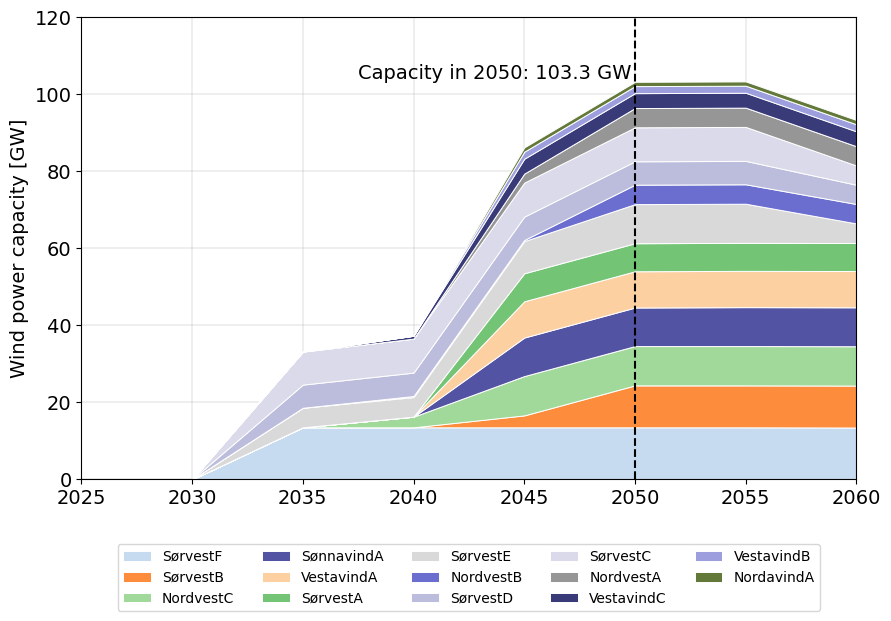

Wind production (floating + grounded) for NO areas for case: NOgrid
NO prod in 2050: 10.4 GW
['NordvestB', 'SørvestF', 'NordavindA', 'NordvestA', 'NordvestC', 'VestavindA', 'SørvestE', 'SørvestC', 'SørvestA', 'SørvestB', 'VestavindE', 'NordavindD', 'SønnavindA']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


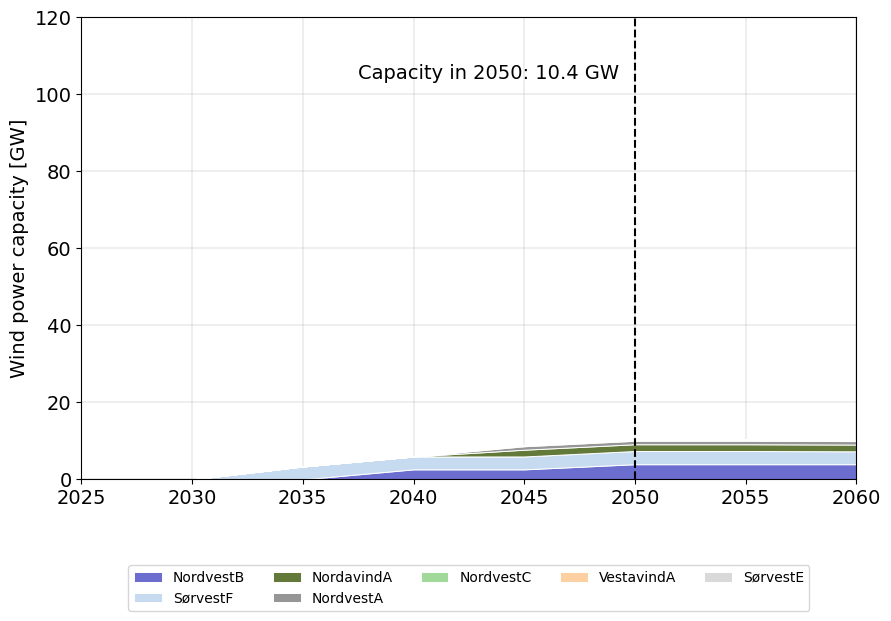

Wind production (floating + grounded) for NO areas for case: NoHubs
NO prod in 2050: 22.6 GW
['SørvestF', 'SørvestE', 'VestavindA', 'NordvestA', 'VestavindC', 'NordvestB', 'NordvestC', 'NordavindA', 'VestavindB', 'SørvestD', 'VestavindF', 'VestavindE', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


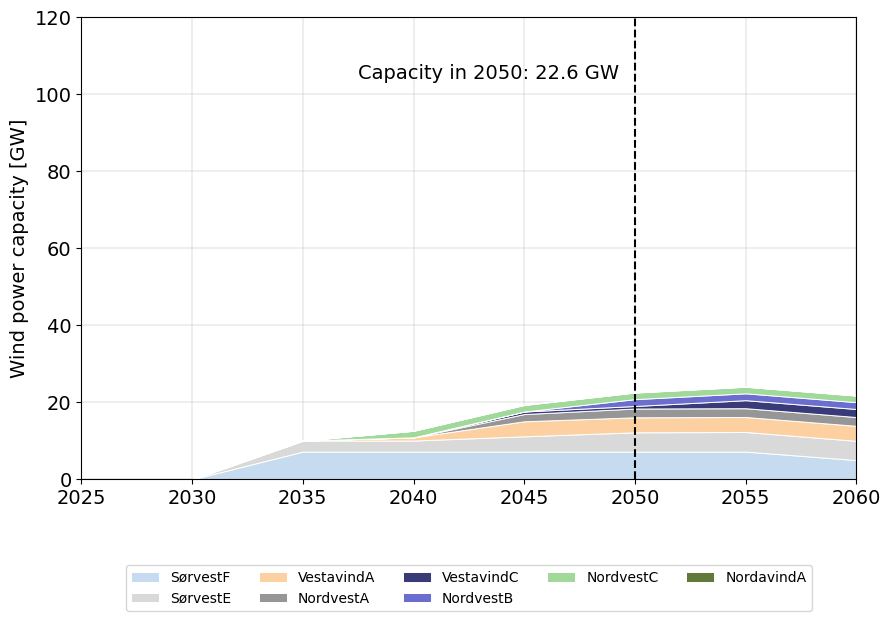

Wind production (floating + grounded) for NO areas for case: NoHubsNOgrid
NO prod in 2050: 10.3 GW


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


['NordvestB', 'SørvestF', 'NordavindA', 'NordvestA', 'VestavindA', 'SørvestE', 'VestavindB', 'VestavindC', 'SørvestB', 'VestavindE', 'NordavindC', 'SønnavindA']


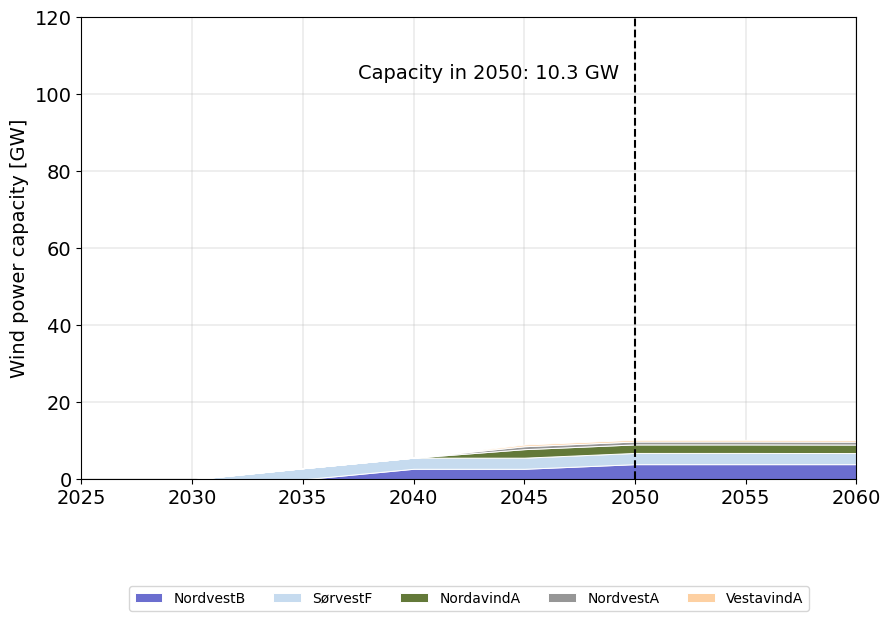

Wind production (floating + grounded) for NO areas for case: OnlyCentral
NO prod in 2050: 57.5 GW
['SørvestF', 'VestavindA', 'SørvestC', 'SørvestD', 'SørvestE', 'SørvestB', 'NordvestA', 'NordvestB', 'NordvestC', 'VestavindC', 'NordavindA', 'SørvestA', 'SønnavindA', 'VestavindF', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


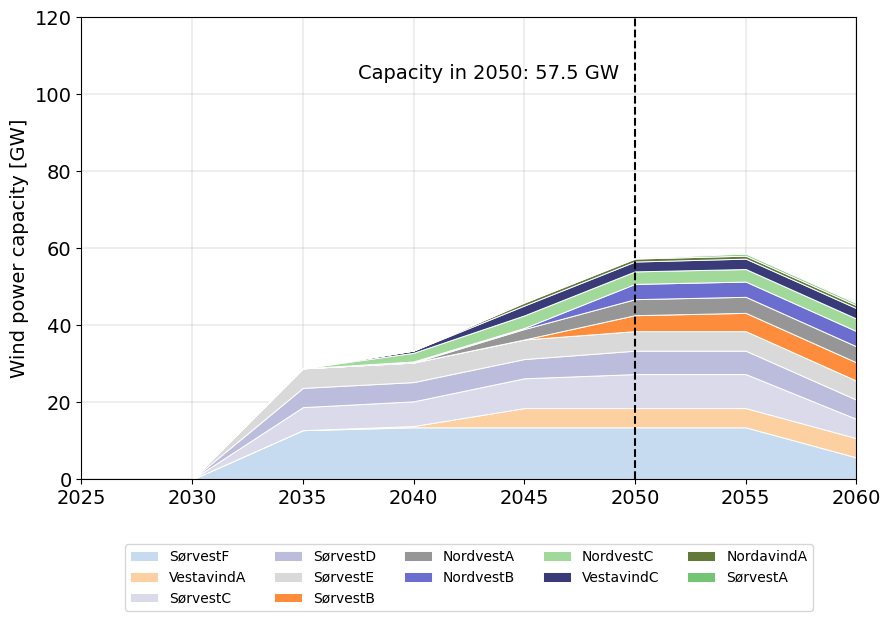

Wind production (floating + grounded) for NO areas for case: OnlyEU
NO prod in 2050: 52.9 GW
['SørvestF', 'VestavindA', 'SørvestC', 'SørvestD', 'NordvestA', 'NordvestB', 'SørvestE', 'NordvestC', 'VestavindC', 'NordavindA', 'SønnavindA', 'SørvestA', 'SørvestB', 'VestavindD', 'VestavindE', 'NordavindC']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


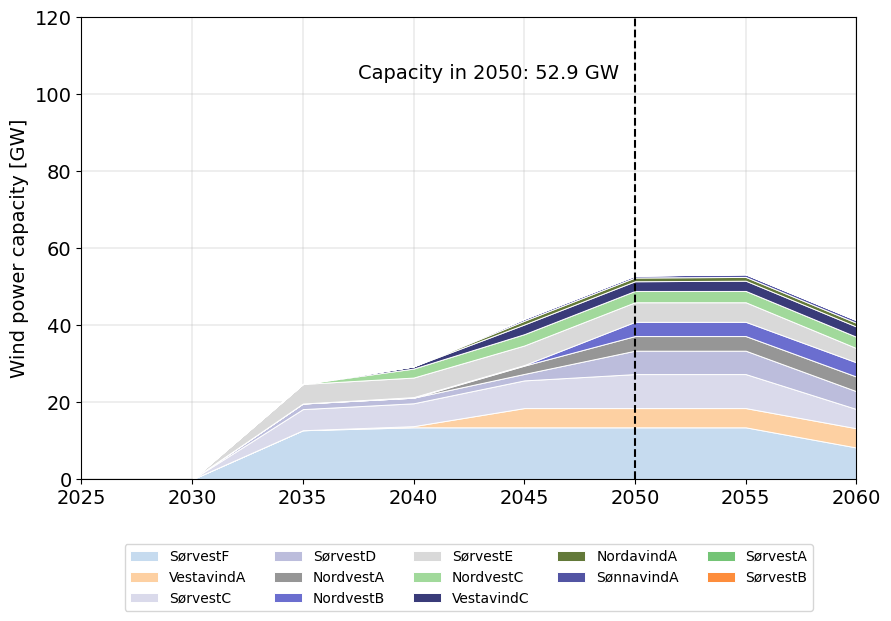

Wind production (floating + grounded) for NO areas for case: OnlyNorth
NO prod in 2050: 58.1 GW
['NordvestC', 'VestavindA', 'SørvestF', 'SørvestC', 'SørvestD', 'SørvestA', 'NordvestA', 'SørvestE', 'VestavindC', 'NordvestB', 'NordavindA', 'SørvestB', 'SønnavindA', 'VestavindF', 'NordavindD', 'NordavindB']


/var/folders/rd/zf3y09wj69n3q6493fx5jmtr0000gn/T/ipykernel_54546/1345482913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind_farm_nodes["genInstalledCap_MW"] = df_wind_farm_nodes.groupby(['Node', 'Period'])['genInstalledCap_MW'].transform('sum')


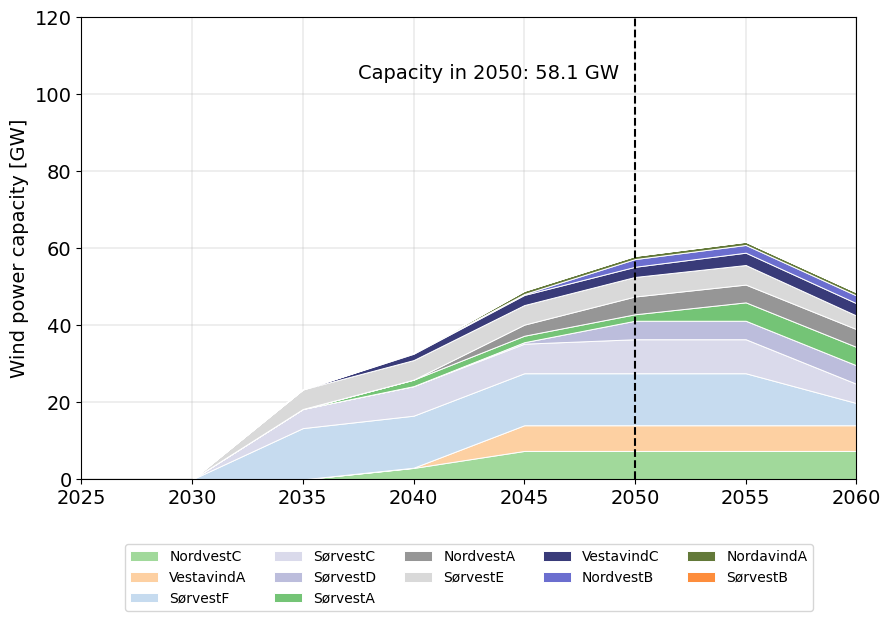

In [17]:
for case, _df in DF_BY_CASES.items():
    plot_wind_prod_NO(case, _df)